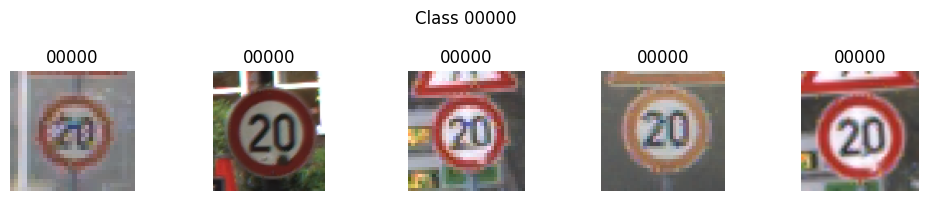

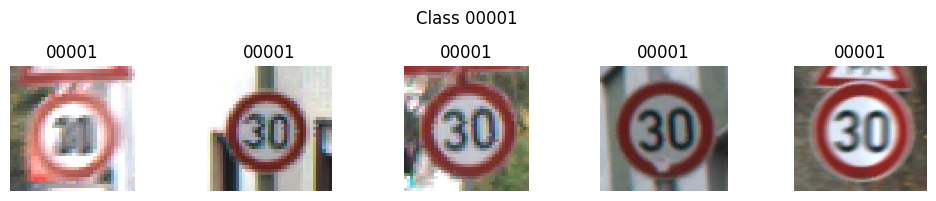

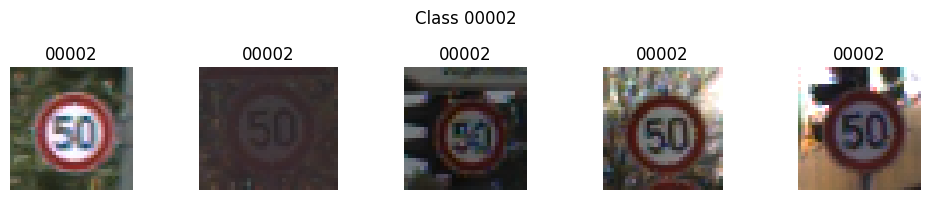

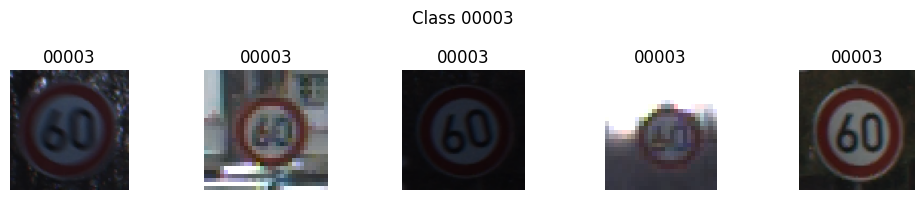

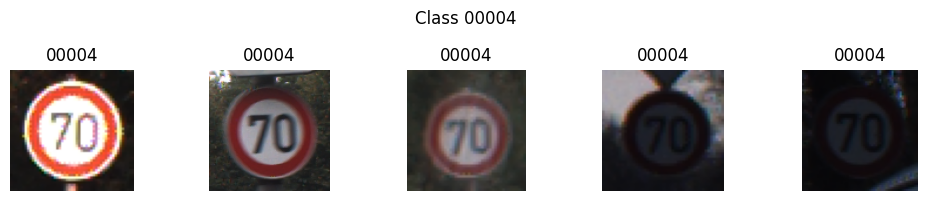

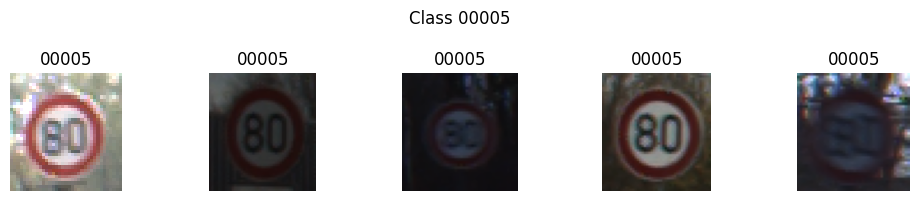

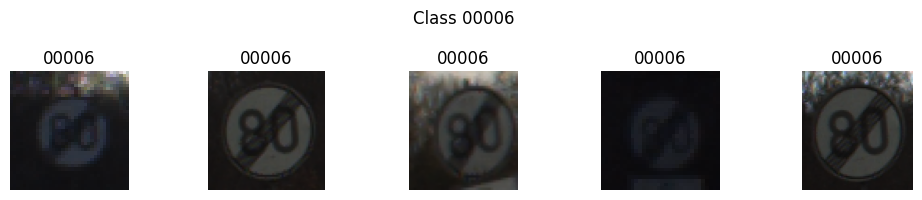

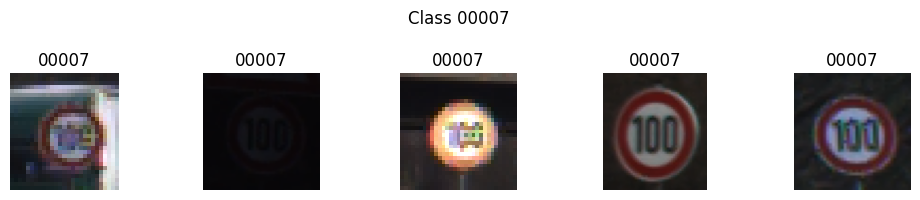

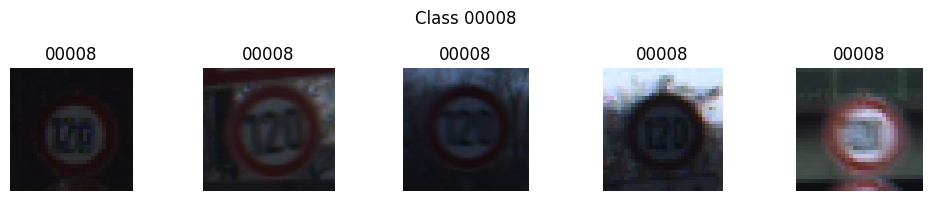

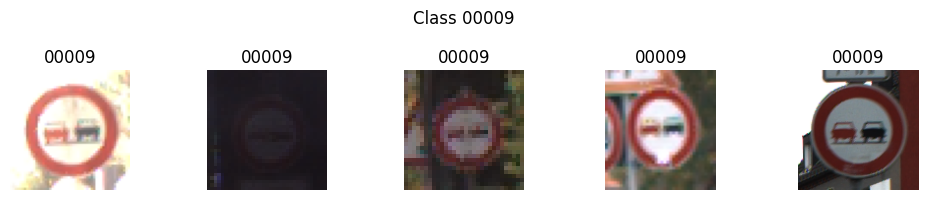

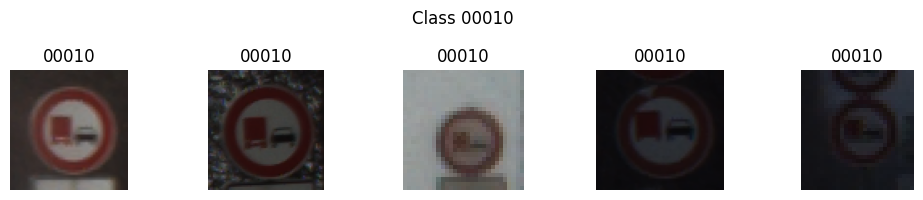

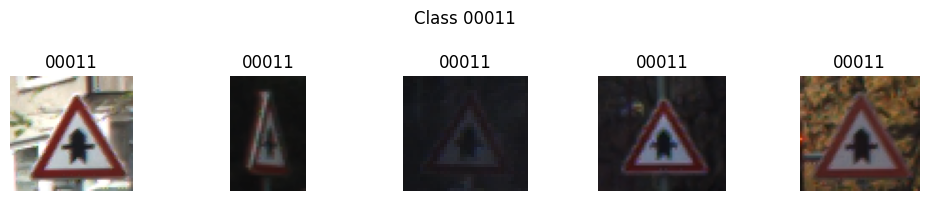

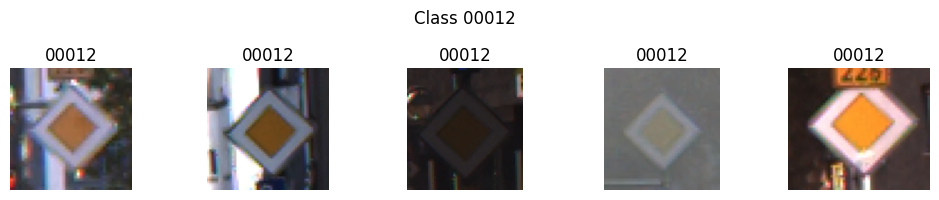

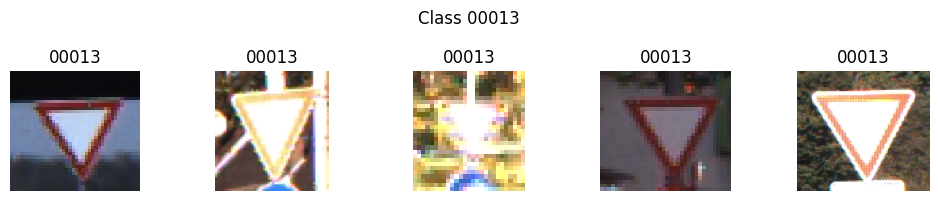

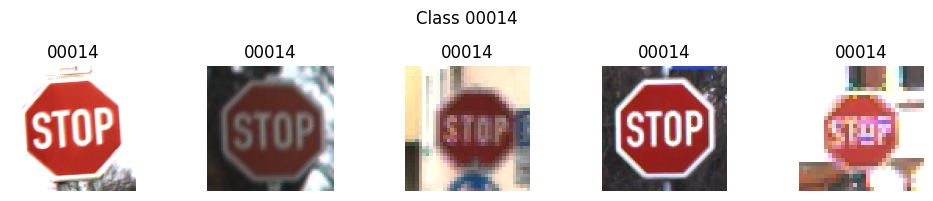

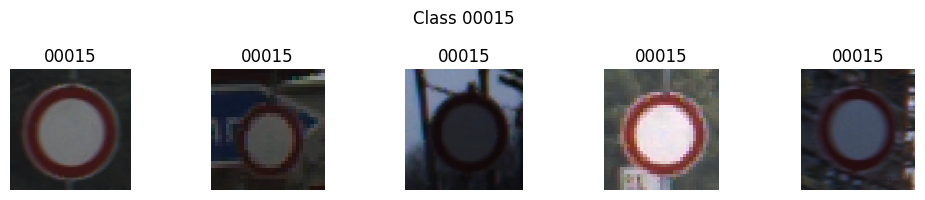

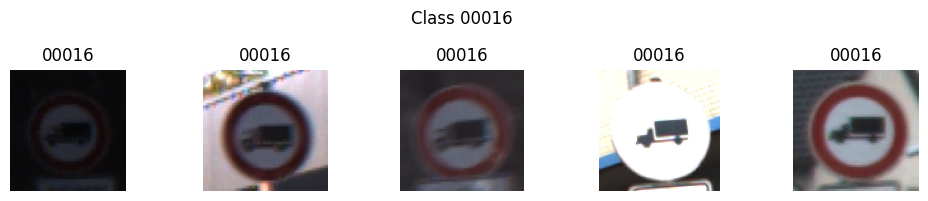

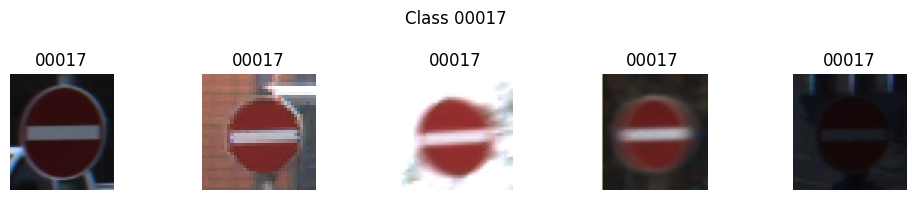

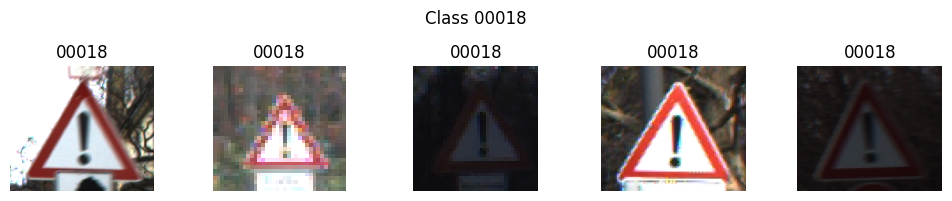

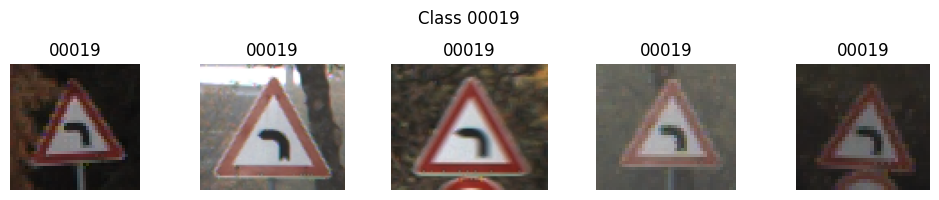

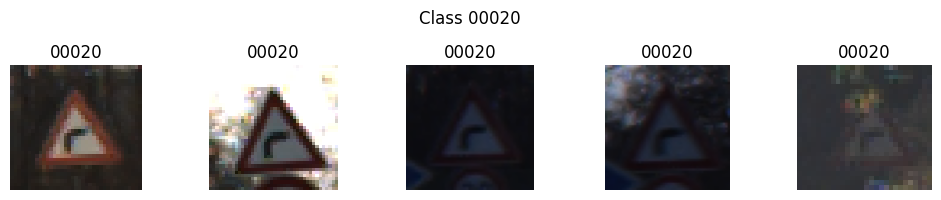

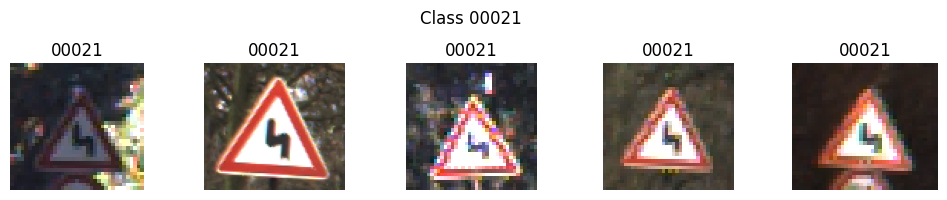

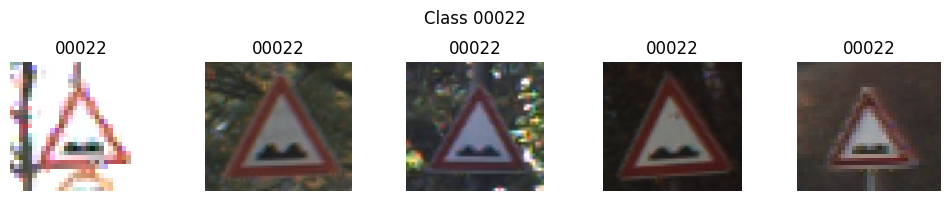

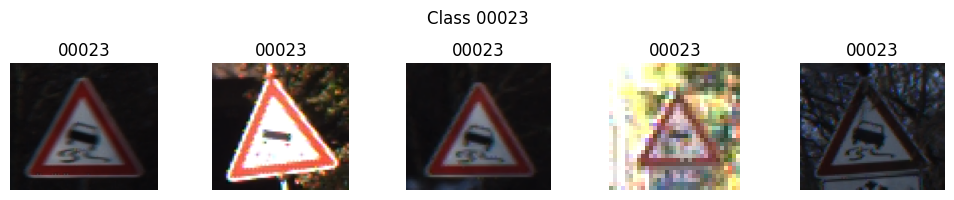

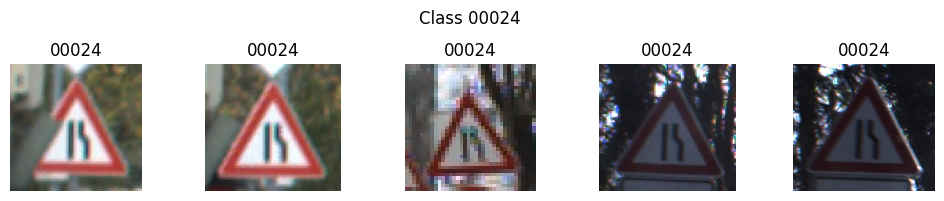

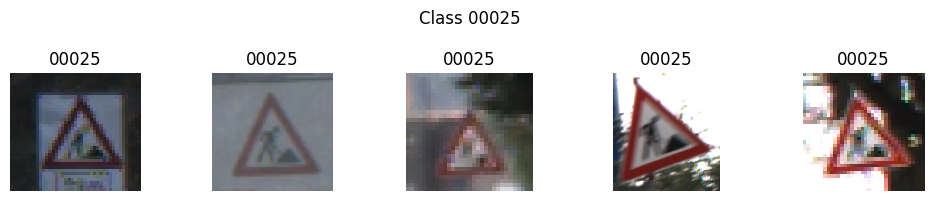

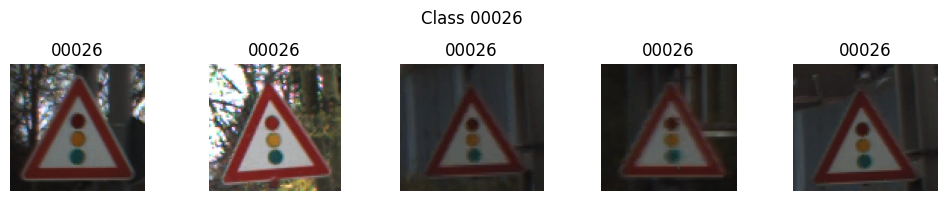

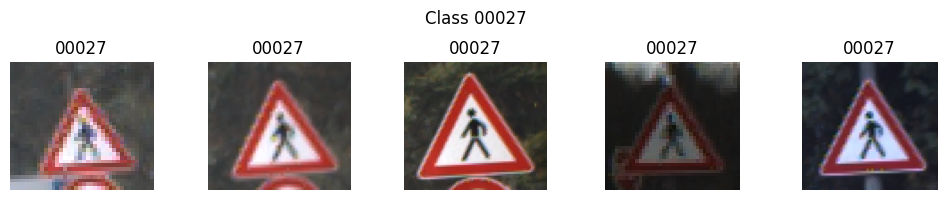

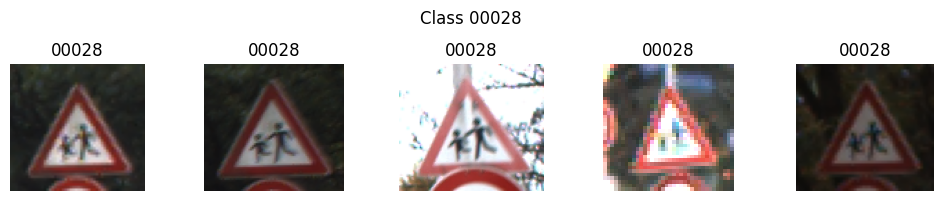

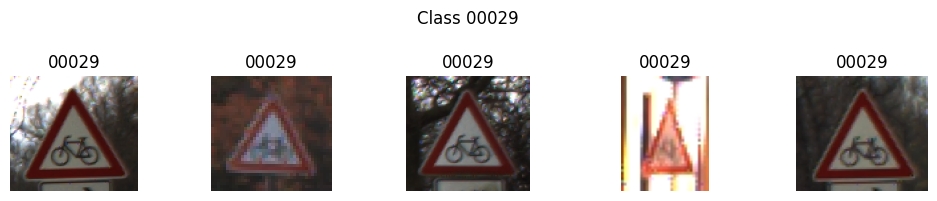

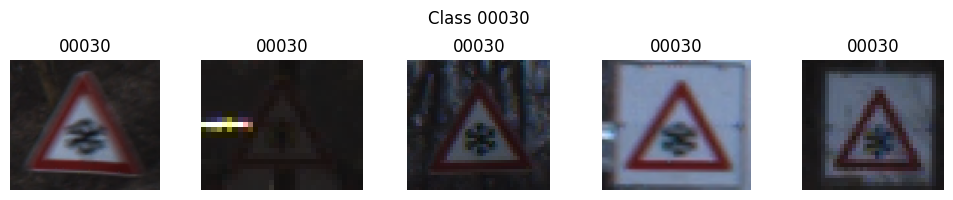

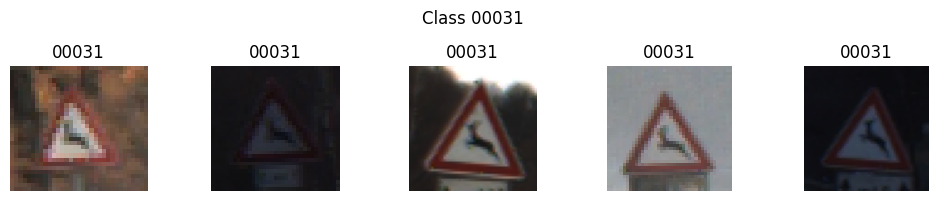

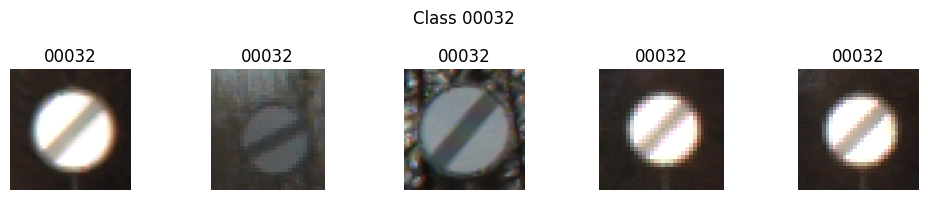

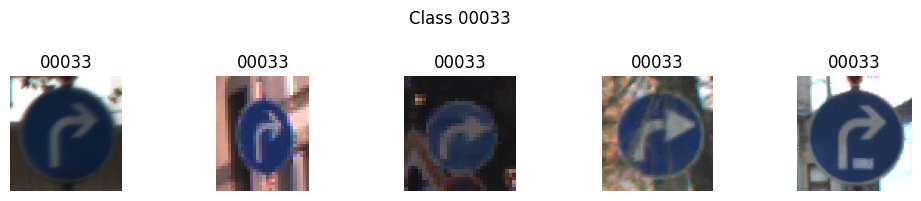

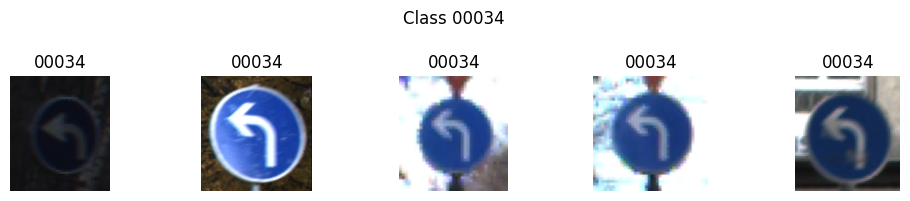

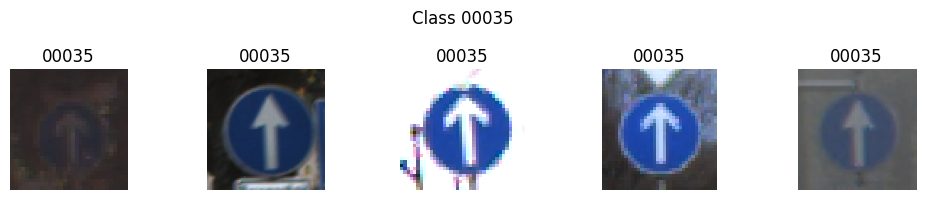

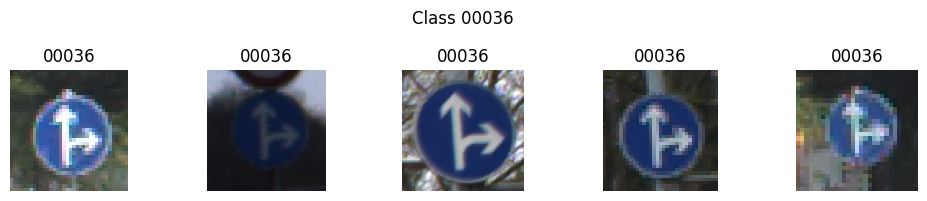

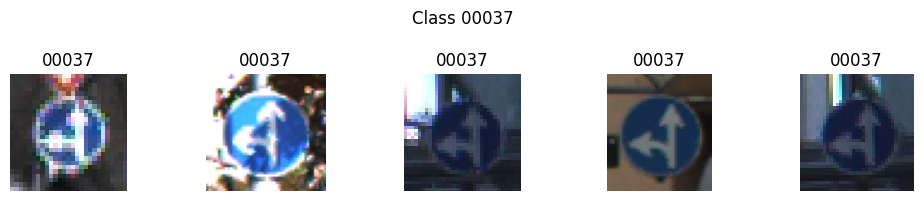

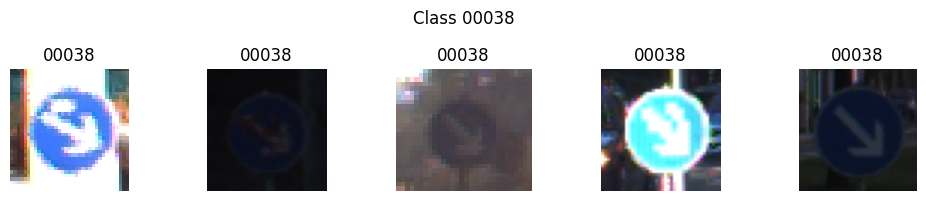

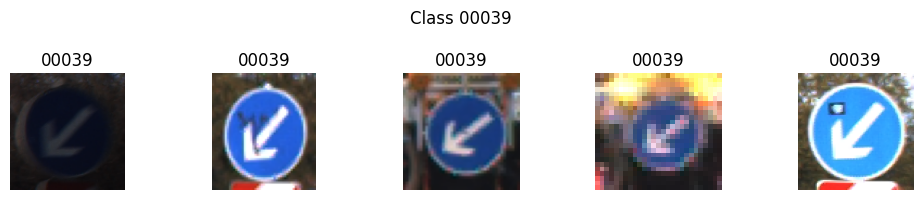

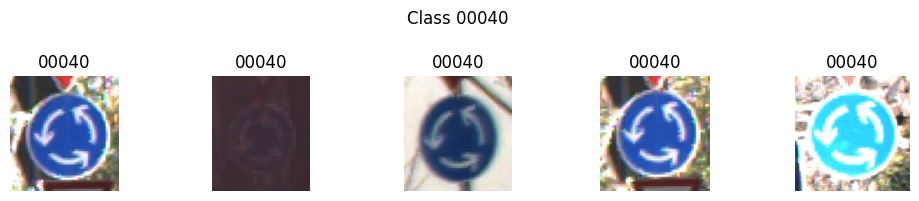

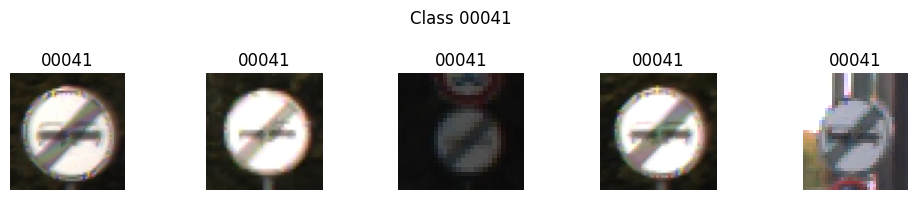

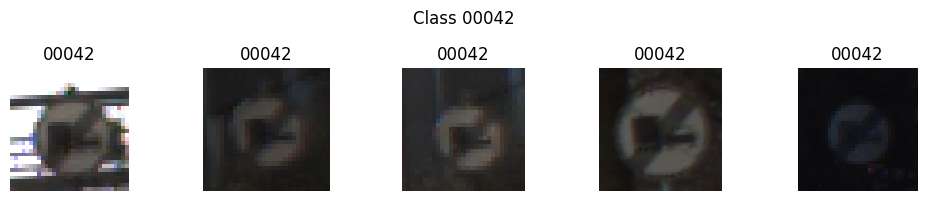

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set your dataset path
root_dir = "/data/cat/ws/srka007f-CV_project/GTSRB/GTSRB/data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"

# Get list of class directories (00000 - 00042)
class_dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Loop through each class
for class_id in class_dirs:
    class_path = os.path.join(root_dir, class_id)
    image_files = [f for f in os.listdir(class_path) if f.endswith(".ppm")]
    
    # Show 5 images
    plt.figure(figsize=(10, 2))
    for i in range(5):
        img_path = os.path.join(class_path, image_files[i])
        img = Image.open(img_path)
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_id}")
    
    plt.suptitle(f"Class {class_id}")
    plt.tight_layout()
    plt.show()


In [2]:
import os
import random
from pathlib import Path

def split_with_symlinks(src_dir, dest_root, split_ratio=0.8, seed=42):
    random.seed(seed)

    src_dir = Path(src_dir)
    dest_root = Path(dest_root)

    if not src_dir.exists():
        raise FileNotFoundError(f"Source directory not found: {src_dir}")

    train_dir = dest_root / "train"
    val_dir = dest_root / "val"

    # Clean up existing split folders if they exist
    for dir_path in [train_dir, val_dir]:
        if dir_path.exists():
            print(f"Removing existing directory: {dir_path}")
            os.system(f"rm -rf {dir_path}")

    class_dirs = [d for d in src_dir.iterdir() if d.is_dir()]

    for class_dir in class_dirs:
        class_name = class_dir.name
        images = list(class_dir.glob("*"))
        if not images:
            continue

        random.shuffle(images)
        split_idx = int(len(images) * split_ratio)
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        for split_name, img_list in zip(["train", "val"], [train_imgs, val_imgs]):
            dest_class_dir = dest_root / split_name / class_name
            dest_class_dir.mkdir(parents=True, exist_ok=True)

            for img_path in img_list:
                symlink_path = dest_class_dir / img_path.name
                try:
                    os.symlink(img_path.resolve(), symlink_path)
                except FileExistsError:
                    continue

    print("✅ Symlinked train/val split completed.")

# === Usage ===

split_with_symlinks(
    src_dir="/data/cat/ws/srka007f-CV_project/GTSRB/GTSRB/data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images",
    dest_root="/data/cat/ws/srka007f-CV_project/GTSRB/GTSRB/data",
    split_ratio=0.8
)


✅ Symlinked train/val split completed.


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    BackupAndRestore,
    CSVLogger
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import numpy as np
import os

# ==== Config ====
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 43
EPOCHS = 50

# ✅ Your original folder paths
TRAIN_DIR = "/data/cat/ws/srka007f-CV_project/GTSRB/GTSRB/data/train and valid/train"
VAL_DIR   = "/data/cat/ws/srka007f-CV_project/GTSRB/GTSRB/data/train and valid/val"
MODEL_NAME = "efficientnet_gtsrb.h5"

# ==== RGB Conversion Function ====
def ensure_rgb(image):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image

# ==== Data Generators ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=ensure_rgb,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=ensure_rgb
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'  # Important but not always enough without preprocessing
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

# ==== Model: EfficientNetB0 ====
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # Freeze base model initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# ==== Compile ====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==== Callbacks ====
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor='val_loss', verbose=1),
    CSVLogger("training_log.csv"),
    BackupAndRestore(backup_dir="./training_backup")
]

# ==== Train ====
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Found 31337 images belonging to 43 classes.
Found 7871 images belonging to 43 classes.


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)